Librerias

In [1]:
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# CNN
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout
#from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam  # Import the legacy optimizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import logging


ModuleNotFoundError: No module named 'tqdm'

Funciones Creadas

In [ ]:


# Supón que labels_marker es el diccionario de etiquetas que ya definiste.
labels_marker = {
    "Marker_1": [1, 0, 0, 0, 0, 0],
    "Marker_2": [0, 1, 0, 0, 0, 0],
    "Marker_3": [0, 0, 1, 0, 0, 0],
    "Marker_4": [0, 0, 0, 1, 0, 0],
    "Marker_5": [0, 0, 0, 0, 1, 0],
    "Marker_6": [0, 0, 0, 0, 0, 1]
}

def load_mat_to_array(file_path, variable_name='eeg_processed'):
    # Cargar el archivo .mat
    try:
        mat_data = loadmat(file_path)
        if variable_name in mat_data:
            array_data = np.array(mat_data[variable_name])
            return array_data
        else:
            raise KeyError(f"Variable '{variable_name}' not found in the .mat file.")
    except Exception as e:
        logging.error(f"Error loading {file_path}: {e}")
        return None

def parse_folders_and_load_data(base_path):
    train_data = []
    train_labels = []

    # Contar el número total de archivos .mat para la barra de progreso
    total_files = sum([len(files) for r, d, files in os.walk(base_path) if any(file.endswith('.mat') for file in files)])
    print('done')
    with tqdm(total=total_files, desc="Processing files") as pbar:
        for subject in os.listdir(base_path):
            subject_path = os.path.join(base_path, subject)
            if os.path.isdir(subject_path):
                for run in os.listdir(subject_path):
                    run_path = os.path.join(subject_path, run)
                    if os.path.isdir(run_path):
                        for marker in os.listdir(run_path):
                            marker_path = os.path.join(run_path, marker)
                            if os.path.isdir(marker_path):
                                for file in os.listdir(marker_path):
                                    if file.endswith('.mat'):
                                        file_path = os.path.join(marker_path, file)
                                        array_data = load_mat_to_array(file_path)
                                        if array_data is not None and array_data.shape == (385, 16): # verificar la forma del vector
                                            train_data.append(array_data)
                                            train_labels.append(labels_marker.get(marker, [0, 0, 0, 0, 0, 0]))
                                        pbar.update(1)

    return np.array(train_data), np.array(train_labels)

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training & validation accuracy and loss values from history and history_s
    ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    ax2.plot(history.history['loss'], label='Train Loss', color='red')
    ax2.plot(history.history['val_loss'], label='Val Loss', color='orange')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')


    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_cuadro_confusion(y_true, y_pred, class_names=["1", "2", "3", "4", "5", "6"]):
    """
    Muestra un cuadro de confusión dado los valores reales y predichos.

    :param y_true: Lista o array de etiquetas verdaderas
    :param y_pred: Lista o array de etiquetas predichas
    :param class_names: Lista opcional de nombres de las clases
    """
    # Calcular el cuadro de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Crear un objeto ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Generar la visualización del cuadro de confusión
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

Procesamos los datos

In [ ]:
# base_path = "/content/drive/MyDrive/MachineLearning/EEG/datos mat/Done" #tesilvay
base_path = "/content/drive/MyDrive/EEG/datos mat/Done" # tomasilvay
total_data, total_labels = parse_folders_and_load_data(base_path)

# Print shapes to verify
print(total_data.shape)
print(total_labels.shape)

done


Processing files: 100%|██████████| 3006/3006 [13:16<00:00,  3.78it/s]

(2956, 385, 16)
(2956, 6)


Histogram with marker distribution

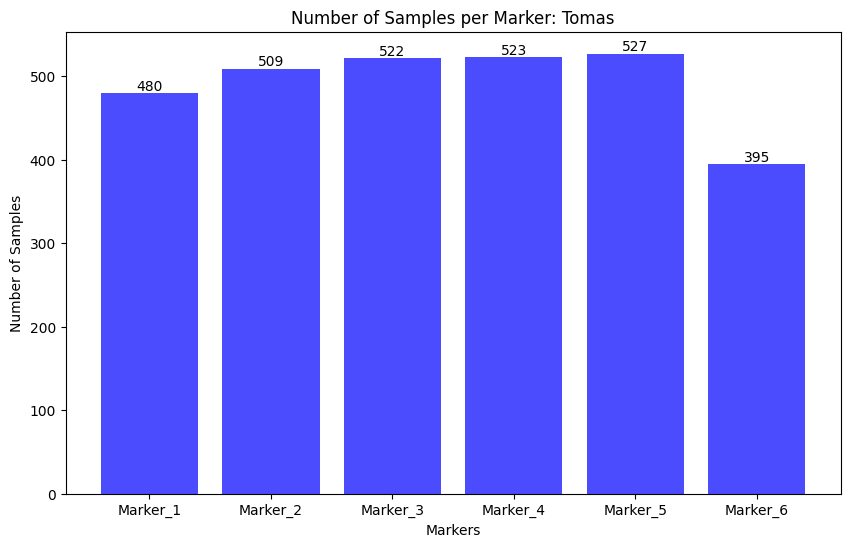

In [ ]:
# {'Marker_1': 331, 'Marker_2': 393, 'Marker_3': 414,
# 'Marker_4': 402, 'Marker_5': 392, 'Marker_6': 295}

# Find the indices of rows that match the target array
samples_per_marker = [np.sum(np.all(total_labels == labels_marker[marker], axis=1)) for marker in labels_marker]
markers = list(labels_marker.keys())

# Crear el histograma
plt.figure(figsize=(10, 6))
bars = plt.bar(markers, samples_per_marker, color='blue', alpha=0.7)

# Añadir etiquetas en la parte superior de cada barra
for bar, count in zip(bars, samples_per_marker):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(count), ha='center', va='bottom')

plt.xlabel('Markers')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Marker: Tomas')
plt.show()


Test Val Splitting

In [ ]:
# Primero, divide en train+val y test
train_val_inputs, test_inputs, train_val_labels, test_labels = train_test_split(
    total_data, total_labels, test_size=0.2, random_state=42)

# Ahora divide train_val en train y val
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_val_inputs, train_val_labels, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

# Verifica las formas para asegurarte de que las divisiones son correctas
print("Train inputs shape:", train_inputs.shape)
print("Validation inputs shape:", val_inputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train inputs shape: (1773, 385, 16)
Validation inputs shape: (591, 385, 16)
Test inputs shape: (592, 385, 16)
Train labels shape: (1773, 6)
Validation labels shape: (591, 6)
Test labels shape: (592, 6)


Red Tomas Pesada

In [ ]:
# Parámetros del modelo
input_shape=(385,16)
optimizer_params = {
    'learning_rate': 0.001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-07,
    'amsgrad': False,
    'name': "adam"
}

optimizer = Adam(**optimizer_params)

model = models.Sequential([
    layers.Conv1D(128, 4, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 4, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 4, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')])

model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

Red Katherine

In [ ]:
# Parámetros del modelo
input_shape = (385, 16)

# Parámetros del optimizador RMSprop
optimizer_params = {
    'learning_rate': 0.001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-07,
    'amsgrad': False,
    'name': "adam"
}

optimizer = tf.keras.optimizers.Adam(**optimizer_params)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, 8, activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 8, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 8, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [ ]:
history = model.fit(train_inputs,
                          train_labels,
                          epochs=50,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(val_inputs, val_labels))

Epoch 1/50
28/28 [==============================] - 2s 30ms/step - loss: 1.7948 - accuracy: 0.1794 - val_loss: 1.7861 - val_accuracy: 0.1726
Epoch 2/50
28/28 [==============================] - 1s 23ms/step - loss: 1.7858 - accuracy: 0.1850 - val_loss: 1.7819 - val_accuracy: 0.2064
Epoch 3/50
28/28 [==============================] - 1s 22ms/step - loss: 1.7828 - accuracy: 0.1895 - val_loss: 1.7769 - val_accuracy: 0.1912
Epoch 4/50
28/28 [==============================] - 1s 23ms/step - loss: 1.7761 - accuracy: 0.2036 - val_loss: 1.7768 - val_accuracy: 0.1777
Epoch 5/50
28/28 [==============================] - 1s 23ms/step - loss: 1.7767 - accuracy: 0.1991 - val_loss: 1.7748 - val_accuracy: 0.2453
Epoch 6/50
28/28 [==============================] - 1s 22ms/step - loss: 1.7772 - accuracy: 0.2149 - val_loss: 1.7749 - val_accuracy: 0.1861
Epoch 7/50
28/28 [==============================] - 1s 21ms/step - loss: 1.7674 - accuracy: 0.2138 - val_loss: 1.7724 - val_accuracy: 0.2064
Epoch 8/50
28

Time to plot everything

19/19 [==============================] - 0s 5ms/step


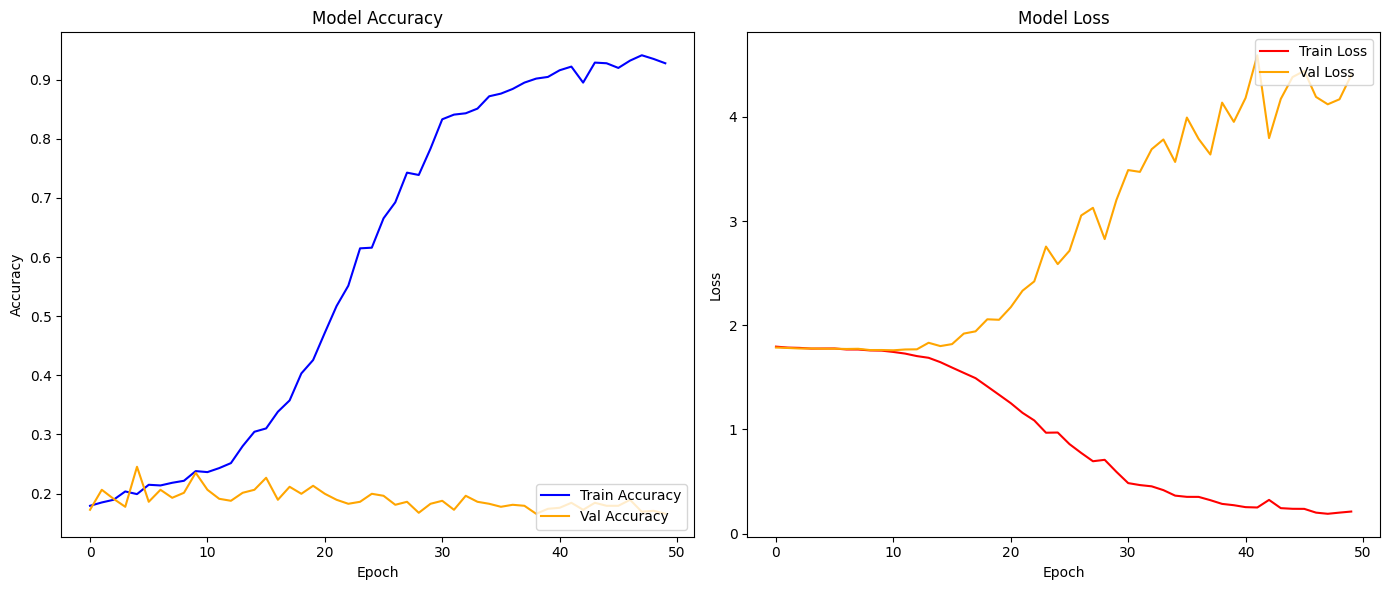

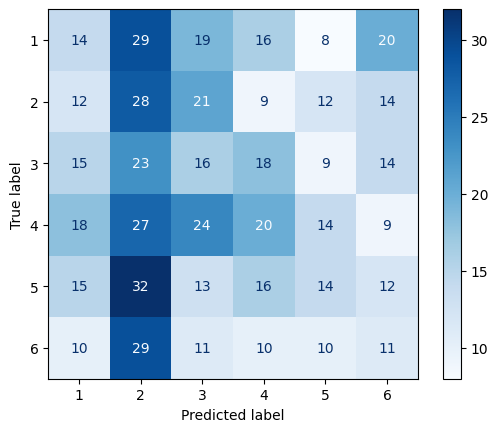

In [ ]:
y_pred = model.predict(test_inputs)
y_pred_classes = np.argmax(y_pred, axis=1)  # Si tu modelo devuelve probabilidades, usa np.argmax para obtener las clases

# Convertir test_labels a etiquetas discretas si están en formato one-hot encoding
if test_labels.ndim > 1 and test_labels.shape[1] > 1:
    test_labels = np.argmax(test_labels, axis=1)

plot_training_history(history)
plot_cuadro_confusion(test_labels, y_pred_classes)

Let's test another dataset to see if the model is shit or not

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import requests, zipfile, io
import os

# Descargar el dataset HAR
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()

# Cargar los datos
def load_har_data():
    # Cargar los datos de entrenamiento
    X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None).values
    y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None).values

    # Cargar los datos de prueba
    X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None).values
    y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', delim_whitespace=True, header=None).values

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_har_data()

# Preprocesar los datos
num_classes = 6
y_train = to_categorical(y_train - 1, num_classes=num_classes)  # Convertir a one-hot encoding
y_test = to_categorical(y_test - 1, num_classes=num_classes)

# Seleccionar solo las primeras 16 características para tener la forma (n_samples, 385, 16)
X_train = X_train[:, :16]
X_test = X_test[:, :16]

# Asegurar que las dimensiones sean correctas para Conv1D (n_samples, 385, 16)
X_train = np.expand_dims(X_train, axis=1)
X_train = np.tile(X_train, (1, 385, 1))

X_test = np.expand_dims(X_test, axis=1)
X_test = np.tile(X_test, (1, 385, 1))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

print("Train inputs shape:", train_inputs.shape)
print("Validation inputs shape:", val_inputs.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)


X_train shape: (7352, 385, 16)
y_train shape: (7352, 6)
X_test shape: (2947, 385, 16)
y_test shape: (2947, 6)
Train inputs shape: (5881, 385, 16)
Validation inputs shape: (1471, 385, 16)
Train labels shape: (5881, 6)
Validation labels shape: (1471, 6)


Epoch 1/10
184/184 [==============================] - 2s 10ms/step - loss: 1.3153 - accuracy: 0.4373 - val_loss: 0.8998 - val_accuracy: 0.5275
Epoch 2/10
184/184 [==============================] - 1s 5ms/step - loss: 0.9747 - accuracy: 0.5120 - val_loss: 0.8632 - val_accuracy: 0.5282
Epoch 3/10
184/184 [==============================] - 1s 5ms/step - loss: 0.9063 - accuracy: 0.5196 - val_loss: 0.8408 - val_accuracy: 0.5472
Epoch 4/10
184/184 [==============================] - 1s 5ms/step - loss: 0.8803 - accuracy: 0.5326 - val_loss: 0.8239 - val_accuracy: 0.5649
Epoch 5/10
184/184 [==============================] - 1s 5ms/step - loss: 0.8608 - accuracy: 0.5365 - val_loss: 0.8206 - val_accuracy: 0.5602
Epoch 6/10
184/184 [==============================] - 1s 5ms/step - loss: 0.8364 - accuracy: 0.5508 - val_loss: 0.7994 - val_accuracy: 0.5670
Epoch 7/10
184/184 [==============================] - 1s 6ms/step - loss: 0.8177 - accuracy: 0.5570 - val_loss: 0.7954 - val_accuracy: 0.5697
Epoch

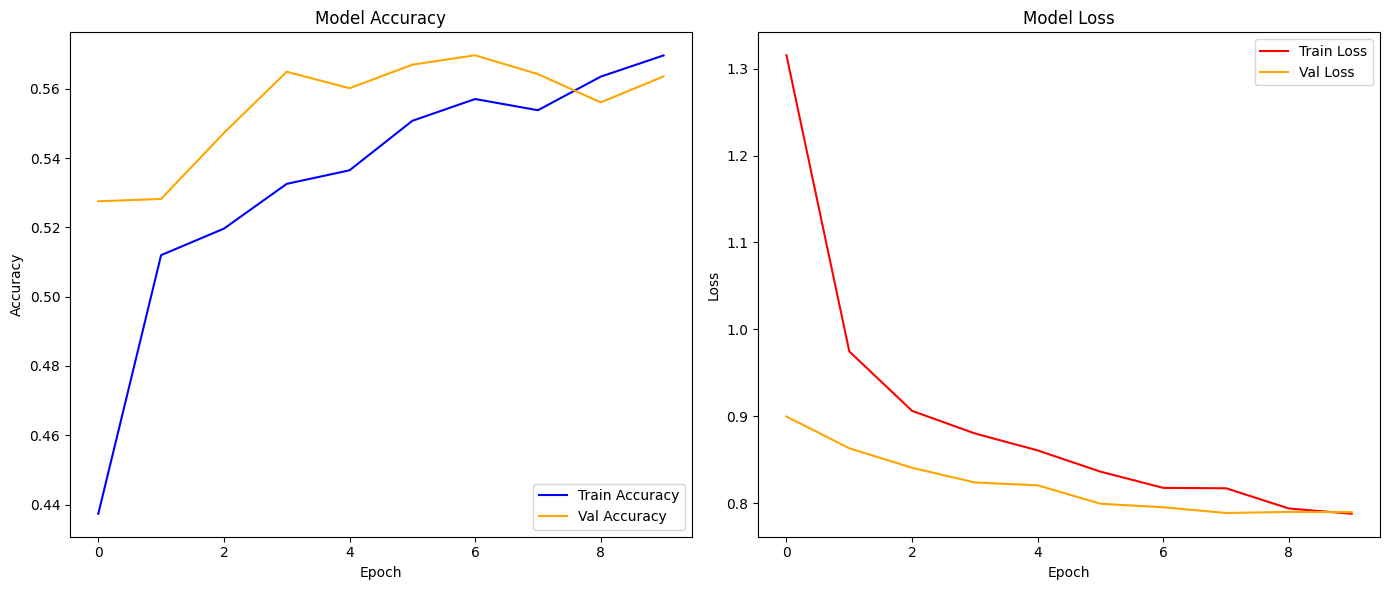

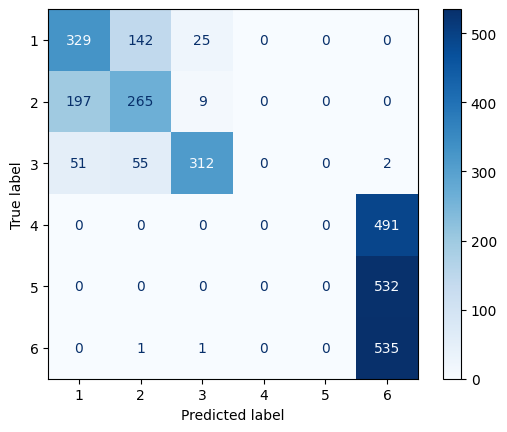

In [ ]:
# Entrenar el modelo
history = model.fit(train_inputs,
                    train_labels,
                    epochs=10,
                    validation_data=(val_inputs, val_labels))

# Evaluar el modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

# Realizar predicciones y mostrar el cuadro de confusión
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

plot_training_history(history)
plot_cuadro_confusion(y_test_classes, y_pred_classes)